# Texture Synthesis with Spatial Generative Adversarial Networks

[Paper](https://arxiv.org/pdf/1611.08207v2.pdf)
[Sample implementation](https://github.com/ubergmann/spatial_gan)


In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi, to_pil
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
import skimage
import skimage.io
import random

In [2]:
BATCH_SIZE = 64
Z_WIDTH, Z_HEIGHT = (8, 8)
OUTPUT_WIDTH, OUTPUT_HEIGHT = (256, 256)
Z_DEPTH = 100
EPOCH_ITERS = 64 * 100
L2_REG = 1e-5

(425, 640, 3)


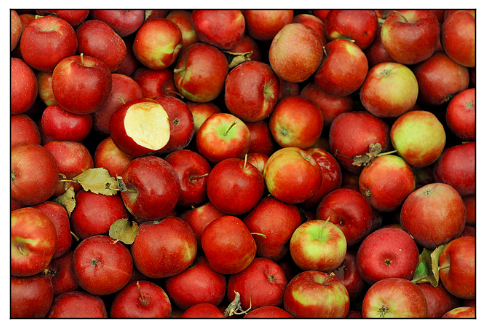

In [3]:
%matplotlib inline

def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img[:,:,:3] # drop alpha channel
    return img / 255.0

image = load_image('../data/apples.jpg.1')
print image.shape
imshow_multi([image])


In [4]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        

def lrelu(x):
    alpha = 0.2
    return tf.maximum(alpha*x, x)

relu = tf.nn.relu

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(axis, [x, -x]))

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

conv_init = lambda shape, dtype, partition_info: np.random.rand(*shape) * 0.1
zero_init = lambda shape, dtype, partition_info: np.random.rand(*shape) * 0

def create_conv(input, out_channels, patch_size=5, stride=1, use_relu=True, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                           shape=[out_channels],
                           initializer=zero_init)
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        return conv+b

def create_deconv(input, out_channels, patch_size=5, stride=1, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                            shape=[out_channels],
                            initializer=zero_init)

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        return deconv + b


In [5]:
source_image = tf.constant(image, tf.float32)
def rand_crop(): return tf.random_crop(source_image, [OUTPUT_WIDTH, OUTPUT_HEIGHT, 3])
real_textures = [rand_crop() for _ in xrange(BATCH_SIZE)]

old_images = tf.placeholder_with_default(
    tf.zeros([BATCH_SIZE, OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]), 
    [BATCH_SIZE, OUTPUT_WIDTH, OUTPUT_HEIGHT, 3], 
    name='old_images')

def generator(image, name='generator'):
    with tf.variable_scope(name):
        layers = [128, 64, 64, 32, 3]
        for i, channels in enumerate(layers):
            is_last = (i == len(layers)-1)
            image = create_deconv(image, channels, patch_size=5, stride=2, name='deconv'+str(i))
            if is_last:
                image = tf.sigmoid(image)
            else:
                image = create_batch_norm(image, name='bn'+str(i))
                # image = concat_elu(image)
                image = relu(image)
        print image.get_shape()
        return image

def discriminator(image, name='discriminator'):
    with tf.variable_scope(name):
        layers = [32, 64, 64, 128, 128]
        for i, channels in enumerate(layers):
            is_last = (i == len(layers)-1)
            image = create_conv(image, channels, patch_size=5, stride=2, name='conv'+str(i))
            image = create_batch_norm(image, name='bn'+str(i))
            image = lrelu(image)
            if not is_last:
                pass
                 #image = create_batch_norm(image, name='bn'+str(i))
                # image = concat_elu(image)
                # image = lrelu(image)
        # image = create_conv(image, 64, patch_size=1, stride=1, name='final1')
        image = create_conv(image, 2, patch_size=1, stride=1, name='final2')
        return image



In [6]:
def compute_disc_output_accuracy(output, target):
    disc_guess = tf.argmax(output, 3)
    disc_correct = tf.equal(tf.cast(disc_guess, tf.int32), target)
    disc_accuracy = tf.reduce_mean(tf.cast(disc_correct, tf.float32))
    return disc_accuracy

def compute_disc_loss(output, target):
    targets = tf.one_hot(target, depth=2, on_value=0.9)
    return tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(output, targets))

scopename = '10'

disc_lr = tf.placeholder_with_default(tf.constant(0.0005), [], name='disc_lr')
gen_lr = tf.placeholder_with_default(tf.constant(0.0005), [], name='gen_lr')

with tf.variable_scope(scopename):

    noise = tf.random_uniform([BATCH_SIZE, Z_WIDTH, Z_HEIGHT, Z_DEPTH], minval=-1, maxval=1)
    synthetic_textures = generator(noise)

    disc_input = tf.concat(0, [real_textures, synthetic_textures]) # , old_images])
    disc_target = tf.concat(0, [
        tf.ones([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32), 
        tf.zeros([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32)
        # tf.zeros([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32)
    ])
    
    disc_output = discriminator(disc_input)
    
    loss = compute_disc_loss(disc_output, disc_target)
    disc_acc = compute_disc_output_accuracy(disc_output, disc_target)
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/discriminator')
    disc_l2 = tf.add_n([ tf.nn.l2_loss(v) for v in disc_vars ]) * L2_REG
    train_disc = tf.train.AdamOptimizer(disc_lr, beta1=0.5).minimize(loss+disc_l2, global_step=global_step, var_list=disc_vars)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/generator')
    gen_l2 = tf.add_n([ tf.nn.l2_loss(v) for v in gen_vars ]) * L2_REG
    train_gen = tf.train.AdamOptimizer(gen_lr, beta1=0.5).minimize(gen_l2-loss, global_step=global_step, var_list=gen_vars)


(64, 256, 256, 3)


In [7]:
session = tf.InteractiveSession()

save_path = 'models/sgan2-256-5'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

import os
saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Did not restore from checkpoint


In [ ]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))
disc_accuracies = []
old_images_ = [np.zeros([OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]) for _ in xrange(BATCH_SIZE)]

i = 0

while True:
    _, step_, disc_acc_, examples_, loss_ = session.run([train_gen, global_step, disc_acc, synthetic_textures, loss], feed_dict={gen_lr: 0.001})
    disc_accuracies.append(disc_acc_)
    
    if len(disc_accuracies) > 0 and avg(disc_accuracies) < 0.85:
        _, step_, disc_acc_ = session.run([train_disc, global_step, disc_acc], feed_dict={old_images: old_images_})
        disc_accuracies.append(disc_acc_)
    
    if random.random() < 0.3:
        old_images_[random.randint(0, len(old_images_)-1)] = examples_[0]
    
    step_rounded = int(step_ / 2) * 2
    if step_rounded % 10 == 0:
        epochs = float(step_) / 2 / EPOCH_ITERS * BATCH_SIZE
        print "Step: {}, epochs: {}, disc accuracy: {}, loss: {}".format(step_, epochs, avg(disc_accuracies), loss_)
        # imshow_multi(examples_[:3])
        disc_accuracies = []
        
        if step_rounded % 200 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'
            else:
                pass
    i += 1


Step: 250, epochs: 1.25, disc accuracy: 0.842529296875, loss: 3280.92602539
Step: 260, epochs: 1.3, disc accuracy: 0.84638671875, loss: 3227.36132812
Step: 261, epochs: 1.305, disc accuracy: 0.854125976562, loss: 3221.9152832
Step: 271, epochs: 1.355, disc accuracy: 0.778552246094, loss: 3466.79272461
Step: 281, epochs: 1.405, disc accuracy: 0.223583984375, loss: 6796.26269531
Step: 291, epochs: 1.455, disc accuracy: 0.628662109375, loss: 4554.58496094
Step: 301, epochs: 1.505, disc accuracy: 0.781433105469, loss: 3904.45556641
Step: 311, epochs: 1.555, disc accuracy: 0.811462402344, loss: 3578.88989258
Step: 321, epochs: 1.605, disc accuracy: 0.832849121094, loss: 3267.03417969
Step: 330, epochs: 1.65, disc accuracy: 0.843573676215, loss: 3162.83862305
Step: 341, epochs: 1.705, disc accuracy: 0.688998135653, loss: 7181.86230469
Step: 351, epochs: 1.755, disc accuracy: 0.220556640625, loss: 5603.1171875
Step: 361, epochs: 1.805, disc accuracy: 0.768615722656, loss: 3704.15942383
Step: 

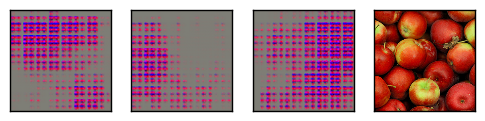

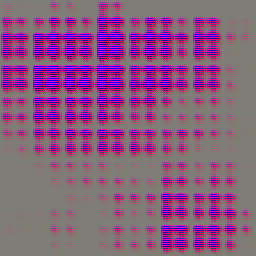

In [13]:
%matplotlib inline
def generate_sample():
    textures, real = session.run([synthetic_textures, real_textures])
    imshow_multi(list(np.clip(textures[:3], 0, 1)) + list(real[:1]))
    return to_pil(textures[0])
generate_sample()